In [1]:
import torch
import wandb
import json
import os

from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as tv_F

from omegaconf import OmegaConf

from model_constructor import construct_model
from datasets import MNIST6_180

In [2]:
# Get the template of the config file used in the experiments
partial_equiv_source = os.path.join(os.getcwd())
config_template = OmegaConf.load(os.path.join(partial_equiv_source, 'cfg/config.yaml'))

#### Restore metadata

In [3]:
rot_interval = 45

run_paths = {
    0: 'dwromero/partial_equiv/l1u7ipu2',
    15: 'dwromero/partial_equiv/bctw3948',
    30: 'dwromero/partial_equiv/6hj1w3vx',
    45: 'dwromero/partial_equiv/j6d7o600',
    60: 'dwromero/partial_equiv/kyqsdgsj',
    90: 'dwromero/partial_equiv/lugcaai4',
}
run_path = run_paths[rot_interval]

In [4]:
used_args = wandb.restore(
    'wandb-metadata.json', run_path,
)
used_args = json.load(used_args)
used_args = OmegaConf.merge(config_template, OmegaConf.from_dotlist(used_args['args']))

In [5]:
used_args

{'net': {'type': 'CKResNet', 'no_hidden': 10, 'no_blocks': 1, 'dropout': 0, 'norm': 'LayerNorm', 'bottleneck_factor_skip_connection': 2, 'block_width_factors': [0.0], 'pool_blocks': [1], 'last_conv_T2': False, 'learnable_final_pooling': False, 'final_spatial_dim': [1, 1]}, 'conv': {'padding': 'same', 'partial_equiv': True, 'bias': True}, 'kernel': {'type': 'SIREN', 'no_hidden': 32, 'no_layers': 3, 'size': 7, 'omega0': 10, 'learn_omega0': False, 'weight_norm': False, 'norm': '', 'activation': ''}, 'base_group': {'name': 'SE2', 'no_samples': 4, 'sample_per_batch_element': False, 'sample_per_layer': True, 'sampling_method': 'random', 'gumbel_init_temp': 0.5, 'gumbel_end_temp': 0.0001}, 'train': {'do': True, 'batch_size': 64, 'epochs': 300, 'lr': 0.001, 'lr_probs': 0.0, 'lr_omega0': 0.0, 'gradient_clip': 0.0, 'weight_decay': 0, 'optimizer': 'Adam', 'optimizer_params': {'nesterov': None, 'momentum': None}, 'scheduler': None, 'scheduler_params': {'decay_steps': -1, 'decay_factor': -1, 'patie

### Initialize wandb

In [6]:
# Initialize weight and bias
os.environ["WANDB_MODE"] = "dryrun"
os.environ["HYDRA_FULL_ERROR"] = "1"

wandb.init(
    project=used_args.wandb.project,
    entity="dwromero",
    reinit=True,
)

/home/romerogudw/anaconda3/envs/partial_equiv/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


#### Create model and load checkpoint

In [7]:
if not isinstance(used_args.base_group.sampling_method, str):
    used_args.base_group.sampling_method = 'random'

model = construct_model(used_args)

# load checkpoint
model_checkpoint = wandb.restore('final_model.pt', run_path)
model.load_state_dict(
            torch.load(model_checkpoint.name, map_location=used_args.device)["model"],
            strict=True,
        )

Automatic Parameters:
 dataset = MNIST6-180, net_type = CKResNet, in_channels = 1,out_channels = 2, sampling_method = SamplingMethods.RANDOM
Block 1/1
Number of parameters: 17063


<All keys matched successfully>

### Get samples from test dataset

In [8]:
dataset = MNIST6_180(
    partition='test',
    augment=used_args.augment,
    root='./data',
)

data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1,
        pin_memory=False,
    )

/home/romerogudw/PycharmProjects/partial_equivariance/datasets/mnist6_180.py:320: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
import matplotlib.pyplot as plt

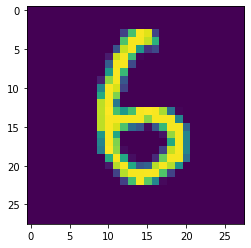

/home/romerogudw/PycharmProjects/partial_equivariance/partial_equiv/partial_gconv/pool.py:22: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  out = torch.max_pool2d(


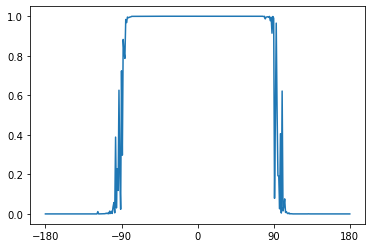

/tmp/ipykernel_11381/4088764395.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.tensor(orientations) < 0.5).sum()


tensor(181)

In [10]:
orientations = torch.linspace(-180, 180, 361)
predictions = []

with torch.no_grad():
    # Iterate through data
    data_iterator = iter(data_loader)

    for _ in range(1):
        next(data_iterator)

    data = next(data_iterator)
    inputs, labels = data

    plt.figure()
    plt.imshow(inputs[0, 0])
    plt.show()

    for rotation in orientations:
        inputs_rot = tv_F.rotate(inputs.clone(), angle=rotation.item(), interpolation=InterpolationMode.BILINEAR)

        inputs_rot = inputs_rot.to(used_args.device)

        outputs = model(inputs_rot)

        _, predicted = torch.max(outputs.data, 1)
        prob_class_1 = torch.softmax(outputs, dim=-1)[0, 0]

        predictions.append(prob_class_1.detach().cpu().item())


plt.figure()
plt.plot(orientations, predictions)
plt.xticks([-180, -90, 0, 90, 180])
plt.show()

(torch.tensor(orientations) < 0.5).sum()

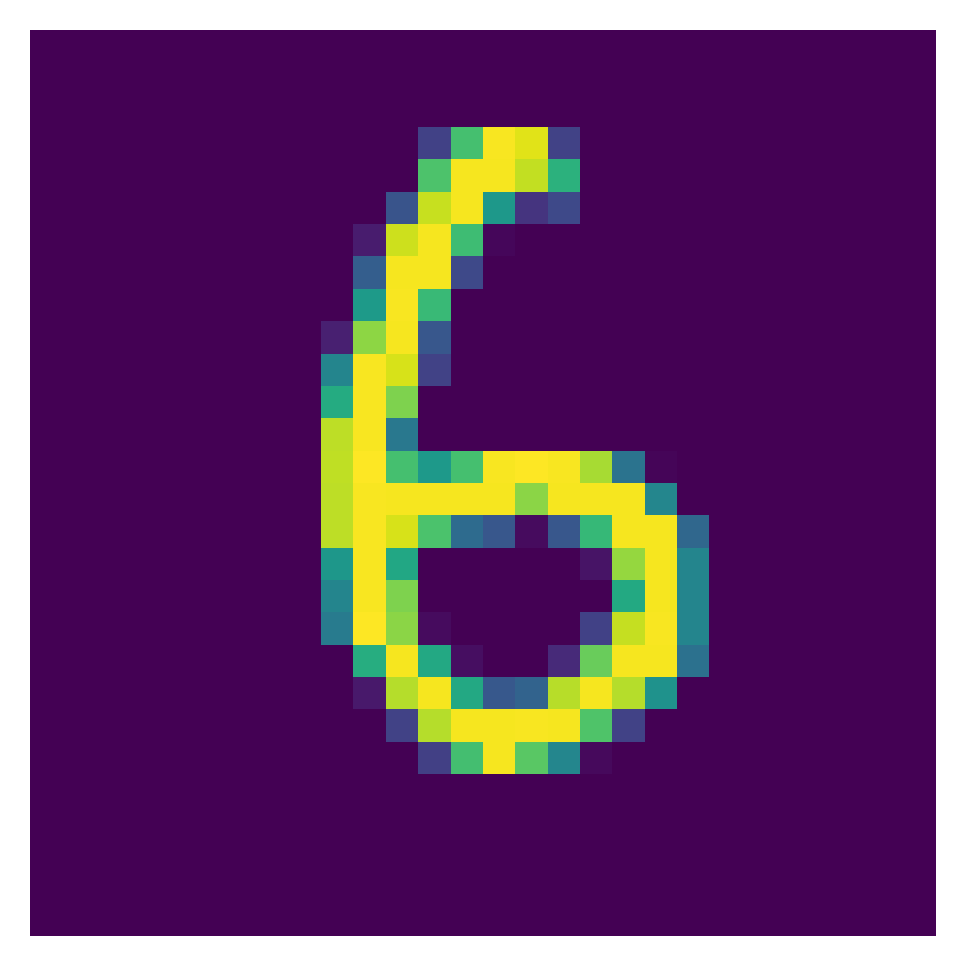

In [11]:
plt.figure(dpi=300)
plt.imshow(inputs[0, 0])
plt.axis('off')
plt.savefig('input.png')
plt.show()

In [12]:
import seaborn as sns
sns.set()

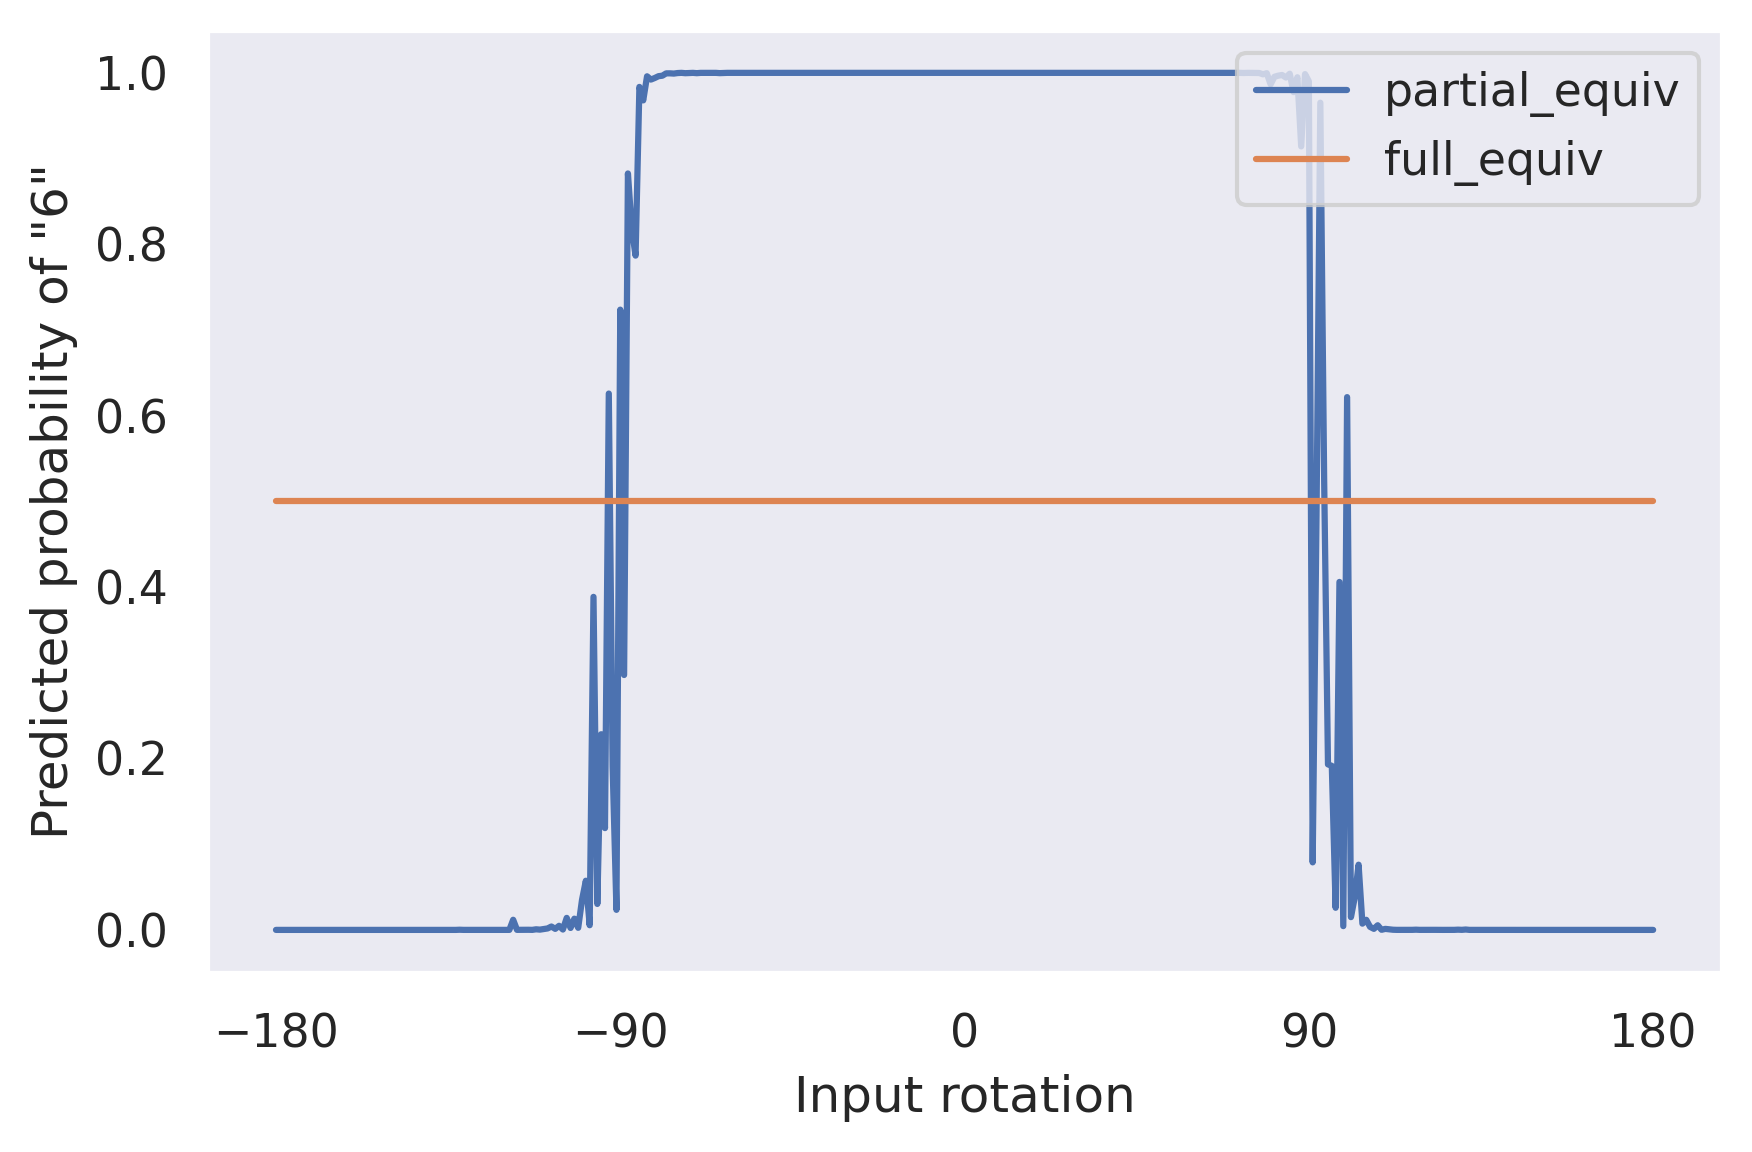

In [15]:
plt.figure(dpi=300)

plt.plot(orientations, predictions, label='partial_equiv')
plt.plot(orientations, 0.5 * torch.ones_like(orientations), label='full_equiv')

plt.grid(False)

plt.ylabel('Predicted probability of "6"')
plt.xlabel('Input rotation')
plt.xticks([-180, -90, 0, 90, 180])
plt.legend(loc='upper right')

plt.tight_layout()

plt.savefig('input_rotations.png')
plt.show()